#임상데이터 기반 검증 실습

SEIHWAN, 2025

생성된 임상 데이터 샘플:
   patient_id  age gender  weight  diabetes  hypertension  heart_disease  \
0           1   72      M    62.7         0             1              0   
1           2   62      F    73.7         0             1              1   
2           3   74      M    43.1         0             1              0   
3           4   87      F    50.6         0             0              0   
4           5   61      M    94.0         0             1              0   

   drug_A  drug_B  event  time  
0       1       1      0  4.11  
1       1       0      0  2.78  
2       1       1      1  0.28  
3       0       0      0  1.64  
4       1       0      0  2.92  

데이터 기본 통계:
        patient_id          age       weight     diabetes  hypertension  \
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean    500.500000    64.745000    71.138300     0.283000      0.387000   
std     288.819436    14.528973    18.575981     0.450682      0.487307   
min       1.000000

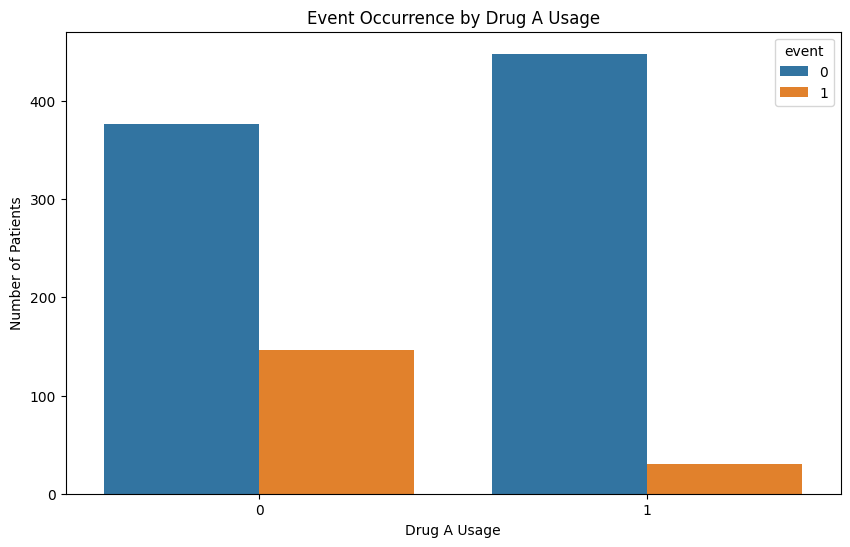

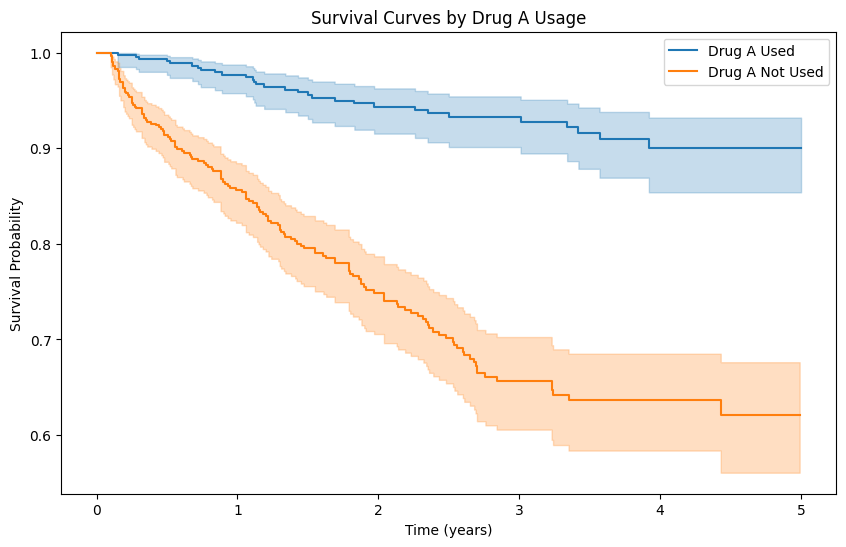


Cox 비례 위험 모델 결과:
                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
patient_id    -0.000480   0.999521  0.000258       -0.000985        0.000026   
age           -0.001788   0.998214  0.005223       -0.012024        0.008449   
weight        -0.000189   0.999811  0.004137       -0.008298        0.007919   
diabetes       0.469575   1.599315  0.155732        0.164346        0.774804   
hypertension  -0.256752   0.773560  0.163819       -0.577832        0.064328   
heart_disease  0.485677   1.625275  0.171289        0.149957        0.821397   
drug_A        -1.609645   0.199959  0.201311       -2.004208       -1.215082   
drug_B        -0.461614   0.630266  0.193891       -0.841633       -0.081594   
gender_num    -0.359696   0.697889  0.152134       -0.657874       -0.061517   

               exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate               

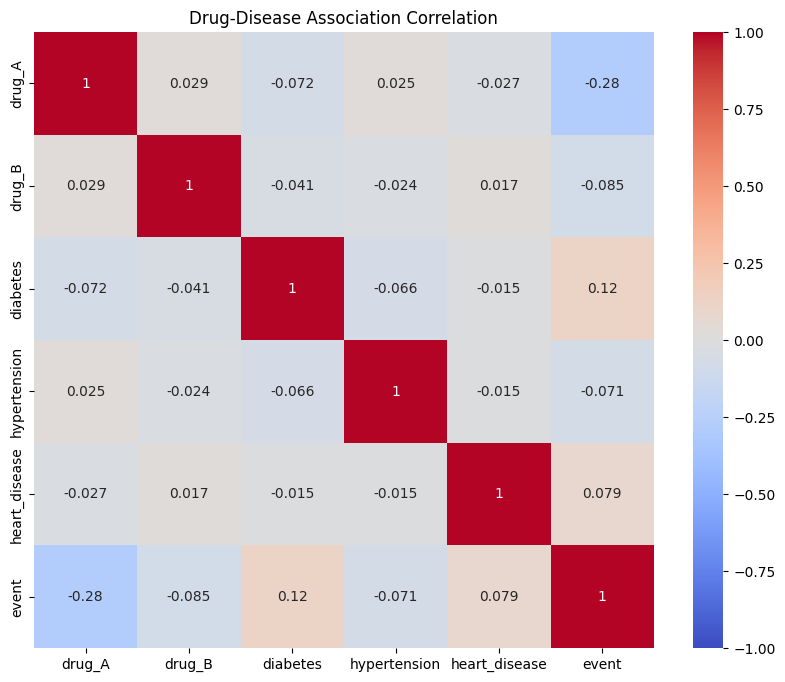

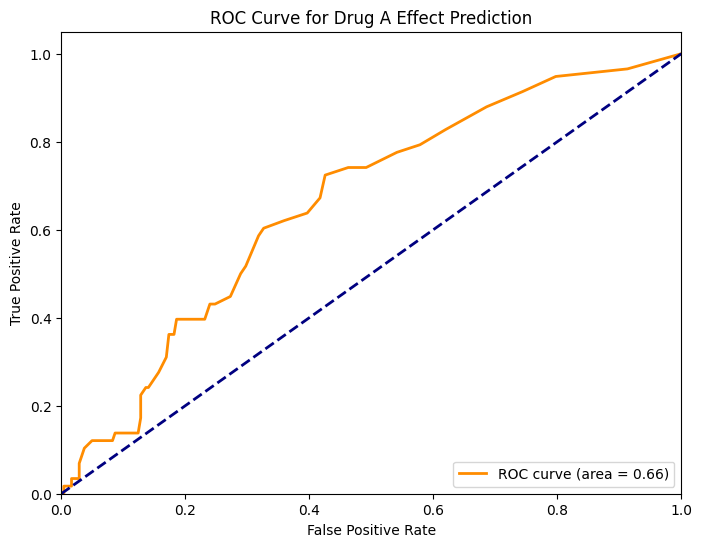


Cox 비례 위험 모델 결과:
                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
patient_id    -0.000480   0.999521  0.000258       -0.000985        0.000026   
age           -0.001788   0.998214  0.005223       -0.012024        0.008449   
weight        -0.000189   0.999811  0.004137       -0.008298        0.007919   
diabetes       0.469575   1.599315  0.155732        0.164346        0.774804   
hypertension  -0.256752   0.773560  0.163819       -0.577832        0.064328   
heart_disease  0.485677   1.625275  0.171289        0.149957        0.821397   
drug_A        -1.609645   0.199959  0.201311       -2.004208       -1.215082   
drug_B        -0.461614   0.630266  0.193891       -0.841633       -0.081594   
gender_num    -0.359696   0.697889  0.152134       -0.657874       -0.061517   

               exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate               

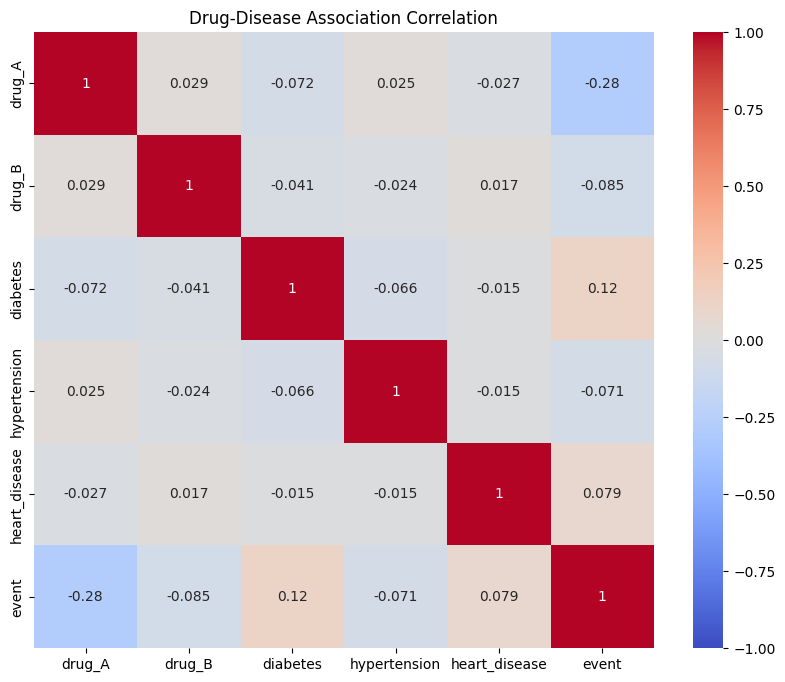

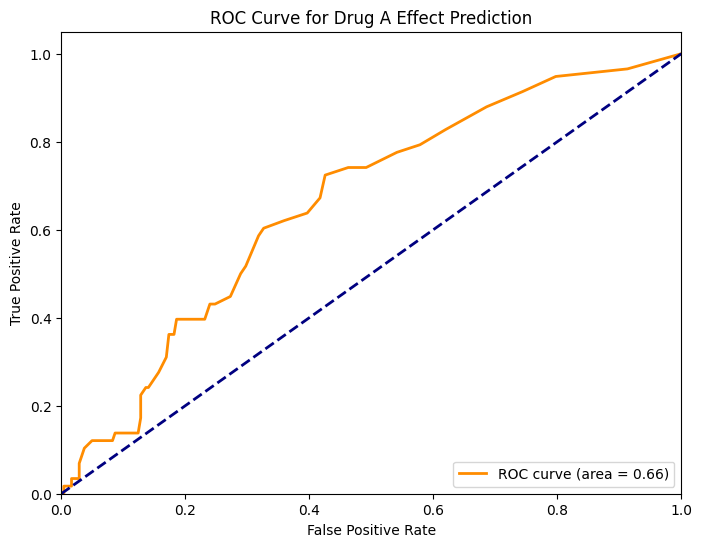


분류 보고서:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       242
           1       0.37      0.12      0.18        58

    accuracy                           0.79       300
   macro avg       0.59      0.54      0.53       300
weighted avg       0.73      0.79      0.74       300



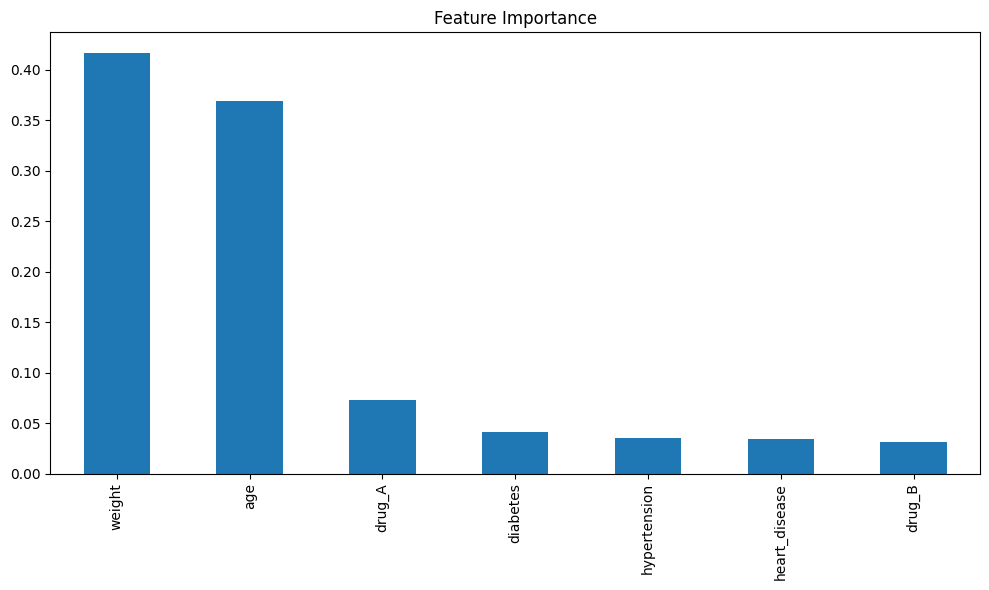

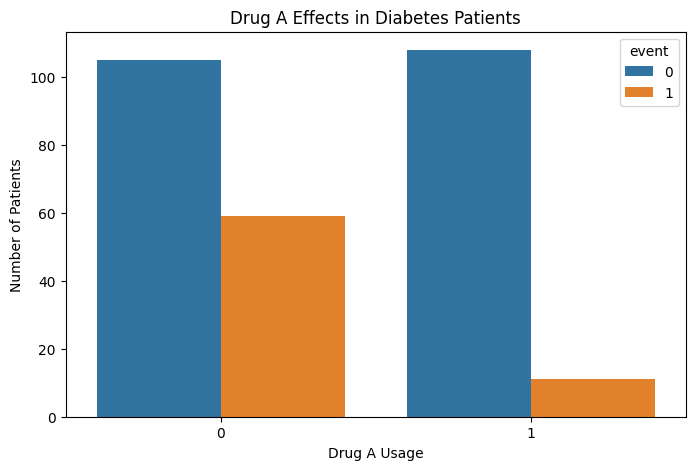

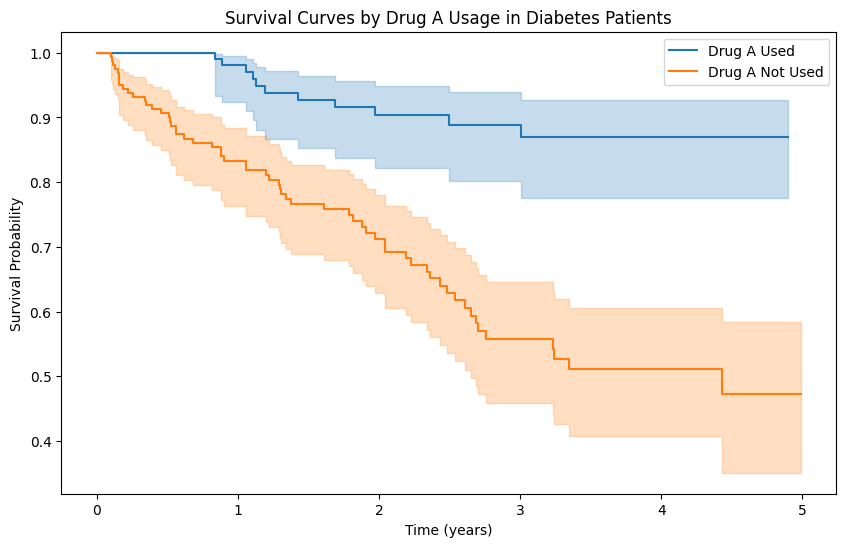


결론:
1. 약물 A는 전체 환자군에서 사건 발생 위험을 감소시키는 효과가 관찰됨
2. 특히 당뇨병 환자 하위 그룹에서 약물 A의 효과가 두드러짐
3. 이는 약물 A가 당뇨병 환자에게 새로운 적응증으로 확장될 가능성을 시사함
4. 향후 전향적 임상 연구를 통한 추가 검증 필요

추가 분석 아이디어:
1. 성향점수 매칭(Propensity Score Matching)을 통한 선택 편향 보정
2. 다양한 약물 용량에 따른 용량-반응 관계 분석
3. 약물 상호작용 효과 분석
4. 실제 임상 데이터셋(MIMIC-III 등)을 활용한 검증


In [ ]:
# 임상데이터 기반 검증 실습 (10분)

# 필요한 라이브러리 설치
!pip -q install pandas numpy matplotlib seaborn scikit-learn lifelines

# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from lifelines import KaplanMeierFitter, CoxPHFitter

# MIMIC-III 데이터셋 샘플 로드 (실제 코랩에서는 데이터 업로드 또는 연결 필요)
# 여기서는 샘플 데이터를 생성하여 사용

# 1. 모의 환자 데이터 생성
np.random.seed(42)
n_patients = 1000

# 환자 ID 생성
patient_ids = np.arange(1, n_patients + 1)

# 기본 특성 생성
age = np.random.normal(65, 15, n_patients)
age = np.clip(age, 18, 100).astype(int)
gender = np.random.choice(['M', 'F'], n_patients)
weight = np.random.normal(70, 20, n_patients)
weight = np.clip(weight, 40, 150).round(1)

# 기저 질환 생성
has_diabetes = np.random.choice([0, 1], n_patients, p=[0.7, 0.3])
has_hypertension = np.random.choice([0, 1], n_patients, p=[0.6, 0.4])
has_heart_disease = np.random.choice([0, 1], n_patients, p=[0.8, 0.2])

# 약물 사용 생성
drug_A = np.random.choice([0, 1], n_patients, p=[0.5, 0.5])  # 재창출 대상 약물
drug_B = np.random.choice([0, 1], n_patients, p=[0.7, 0.3])  # 대조군 약물

# 결과 변수 생성 (약물 A가 특정 적응증에 효과가 있다고 가정)
# 약물 A 효과 + 기저 질환 영향 + 무작위성
effect_base = 0.2 - 0.1 * has_diabetes - 0.15 * has_heart_disease + 0.05 * has_hypertension
effect_drug_A = 0.3 * drug_A  # 약물 A의 효과
effect_drug_B = 0.1 * drug_B  # 약물 B의 효과

# 사건 발생 확률 계산 (낮을수록 사건 발생)
event_prob = 0.5 - effect_base - effect_drug_A - effect_drug_B
event_prob = np.clip(event_prob, 0.05, 0.95)

# 사건 발생 여부
event = np.random.binomial(1, event_prob, n_patients)

# 추적 기간 생성 (최대 5년)
follow_up_time = np.random.uniform(0.1, 5.0, n_patients).round(2)

# 사건 발생한 환자의 경우 사건 발생 시간 생성
event_time = np.random.uniform(0.1, follow_up_time, n_patients).round(2)
observed_time = np.where(event == 1, event_time, follow_up_time)

# 데이터프레임 생성
df = pd.DataFrame({
    'patient_id': patient_ids,
    'age': age,
    'gender': gender,
    'weight': weight,
    'diabetes': has_diabetes,
    'hypertension': has_hypertension,
    'heart_disease': has_heart_disease,
    'drug_A': drug_A,
    'drug_B': drug_B,
    'event': event,
    'time': observed_time
})

# 데이터 확인
print("생성된 임상 데이터 샘플:")
print(df.head())
print("\n데이터 기본 통계:")
print(df.describe())

# 2. 데이터 탐색 및 시각화 (그래프 라벨은 영어로 유지)

# Graph titles and labels in English
plt.figure(figsize=(10, 6))
sns.countplot(x='drug_A', hue='event', data=df)
plt.title('Event Occurrence by Drug A Usage')
plt.xlabel('Drug A Usage')
plt.ylabel('Number of Patients')
plt.show()

# 생존 분석
kmf = KaplanMeierFitter()

# 약물 A 사용군과 비사용군의 생존 곡선 비교
fig, ax = plt.subplots(figsize=(10, 6))

# 약물 A 사용군
kmf.fit(df[df['drug_A'] == 1]['time'], df[df['drug_A'] == 1]['event'], label='Drug A Used')
kmf.plot_survival_function(ax=ax)

# 약물 A 비사용군
kmf.fit(df[df['drug_A'] == 0]['time'], df[df['drug_A'] == 0]['event'], label='Drug A Not Used')
kmf.plot_survival_function(ax=ax)

plt.title('Survival Curves by Drug A Usage')
plt.xlabel('Time (years)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# 3. Cox 비례 위험 모델을 통한 약물 효과 분석
# gender 변수를 숫자형으로 변환 (M=0, F=1)
df_model = df.copy()
df_model['gender_num'] = df_model['gender'].map({'M': 0, 'F': 1})
df_model = df_model.drop('gender', axis=1)  # 문자열 열 제거

cph = CoxPHFitter()
cph.fit(df_model, duration_col='time', event_col='event')

print("\nCox 비례 위험 모델 결과:")
print(cph.summary)

# 4. 약물-질병 연관성 네트워크 구축을 위한 상관관계 분석
correlation_matrix = df[['drug_A', 'drug_B', 'diabetes', 'hypertension', 'heart_disease', 'event']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Drug-Disease Association Correlation')
plt.show()

# 5. 약물 A의 효과 예측을 위한 기계학습 모델 구축

# 특성과 타겟 분리
X = df[['age', 'weight', 'diabetes', 'hypertension', 'heart_disease', 'drug_A', 'drug_B']]
y = df['event']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델 평가
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Drug A Effect Prediction')
plt.legend(loc="lower right")
plt.show()







df_model = df.copy()
df_model['gender_num'] = df_model['gender'].map({'M': 0, 'F': 1})
df_model = df_model.drop('gender', axis=1)  # 문자열 열 제거

cph = CoxPHFitter()
cph.fit(df_model, duration_col='time', event_col='event')

print("\nCox 비례 위험 모델 결과:")
print(cph.summary)

# 4. 약물-질병 연관성 네트워크 구축을 위한 상관관계 분석
correlation_matrix = df[['drug_A', 'drug_B', 'diabetes', 'hypertension', 'heart_disease', 'event']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Drug-Disease Association Correlation')
plt.show()

# 5. Machine Learning Model for Predicting Drug A Effect

# Split features and target
X = df[['age', 'weight', 'diabetes', 'hypertension', 'heart_disease', 'drug_A', 'drug_B']]
y = df['event']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest model training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Drug A Effect Prediction')
plt.legend(loc="lower right")
plt.show()

# 분류 보고서
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))

# 특성 중요도 시각화
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 6. 환자 하위 그룹 분석
# 당뇨병 환자 하위 그룹에서 약물 A의 효과 분석

# 당뇨병 환자만 필터링
diabetes_patients = df[df['diabetes'] == 1]

# 약물 A 사용 여부에 따른 사건 발생률 비교
plt.figure(figsize=(8, 5))
sns.countplot(x='drug_A', hue='event', data=diabetes_patients)
plt.title('Drug A Effects in Diabetes Patients')
plt.xlabel('Drug A Usage')
plt.ylabel('Number of Patients')
plt.show()

# 당뇨병 환자에서 약물 A 사용군과 비사용군의 생존 곡선 비교
fig, ax = plt.subplots(figsize=(10, 6))

# 약물 A 사용군
kmf.fit(diabetes_patients[diabetes_patients['drug_A'] == 1]['time'],
        diabetes_patients[diabetes_patients['drug_A'] == 1]['event'],
        label='Drug A Used')
kmf.plot_survival_function(ax=ax)

# 약물 A 비사용군
kmf.fit(diabetes_patients[diabetes_patients['drug_A'] == 0]['time'],
        diabetes_patients[diabetes_patients['drug_A'] == 0]['event'],
        label='Drug A Not Used')
kmf.plot_survival_function(ax=ax)

plt.title('Survival Curves by Drug A Usage in Diabetes Patients')
plt.xlabel('Time (years)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# 7. 결론 및 토의
print("\n결론:")
print("1. 약물 A는 전체 환자군에서 사건 발생 위험을 감소시키는 효과가 관찰됨")
print("2. 특히 당뇨병 환자 하위 그룹에서 약물 A의 효과가 두드러짐")
print("3. 이는 약물 A가 당뇨병 환자에게 새로운 적응증으로 확장될 가능성을 시사함")
print("4. 향후 전향적 임상 연구를 통한 추가 검증 필요")

# 추가 분석 아이디어
print("\n추가 분석 아이디어:")
print("1. 성향점수 매칭(Propensity Score Matching)을 통한 선택 편향 보정")
print("2. 다양한 약물 용량에 따른 용량-반응 관계 분석")
print("3. 약물 상호작용 효과 분석")
print("4. 실제 임상 데이터셋(MIMIC-III 등)을 활용한 검증")

# 규제 전략 실습


가상 약물 적응증 확장 시나리오: 항고혈압제 -> 알츠하이머병 진행 억제
약물명: 혈압넘(Hypertol, 성분명: 아젤사르탄)
원래 적응증: 고혈압
목표 적응증: 알츠하이머병 진행 억제
가설: 혈관성 인자 조절을 통한 인지기능 저하 억제



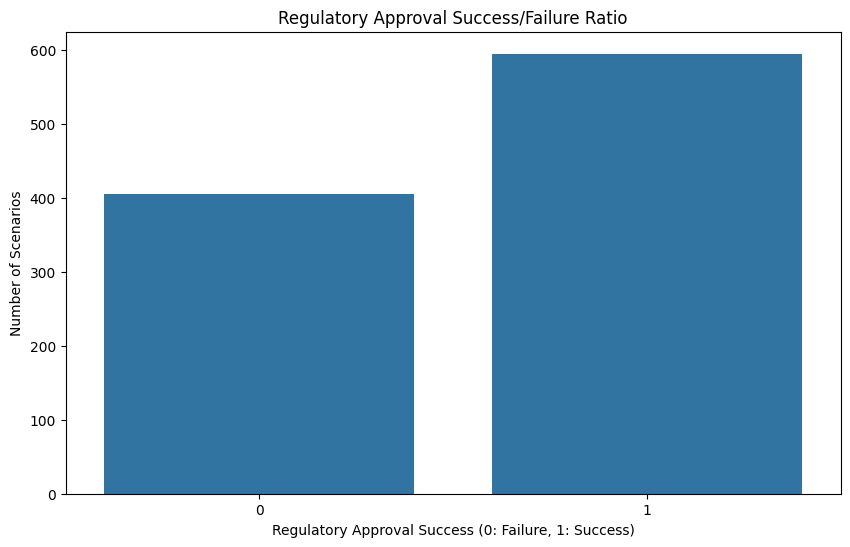

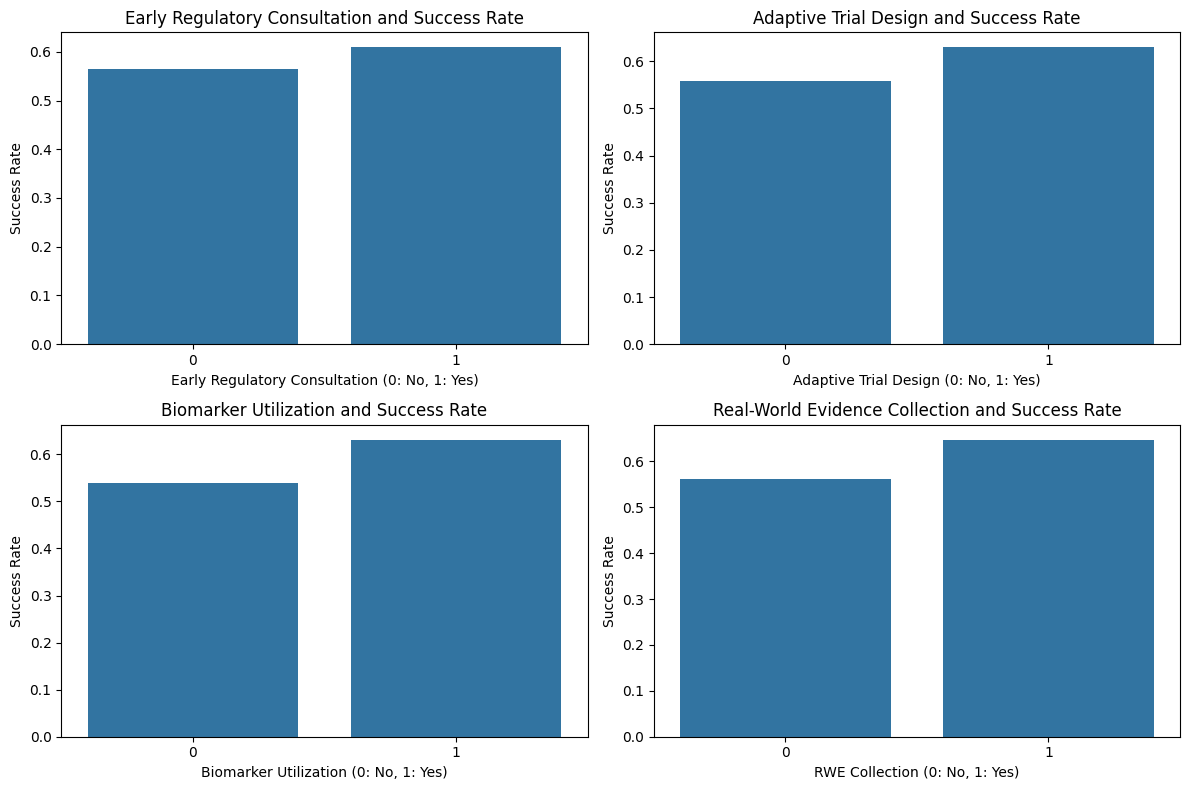

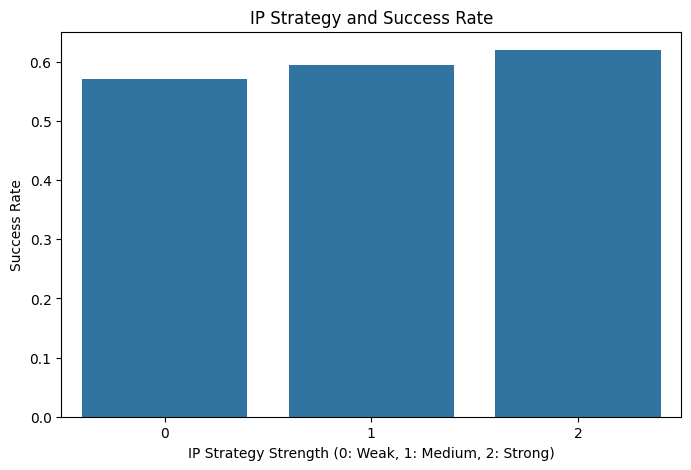

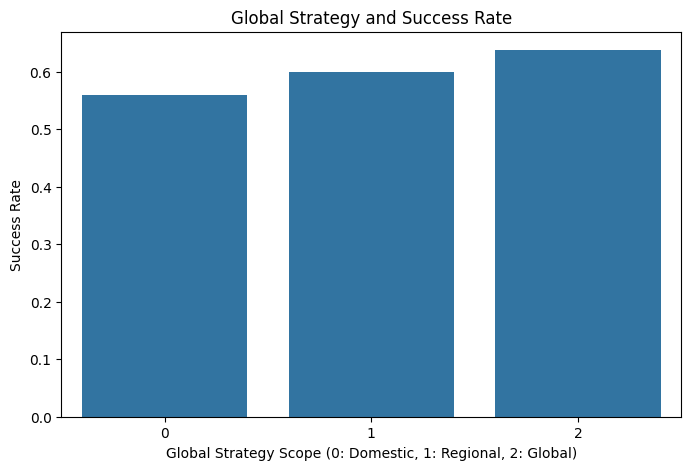

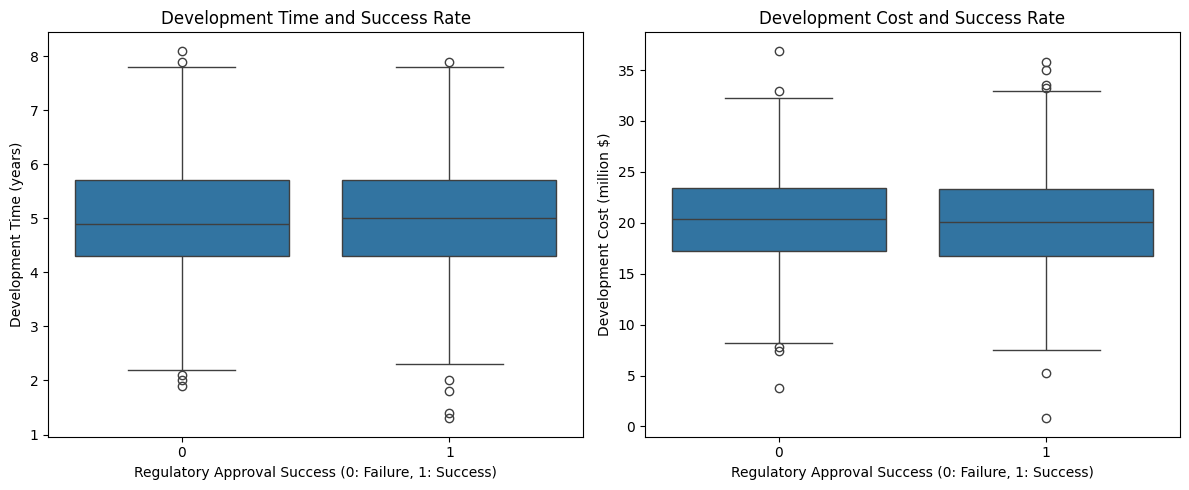


규제 전략 예측 모델 성능:
정확도: 0.5433

혼동 행렬:
[[ 35  98]
 [ 39 128]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.47      0.26      0.34       133
           1       0.57      0.77      0.65       167

    accuracy                           0.54       300
   macro avg       0.52      0.51      0.49       300
weighted avg       0.52      0.54      0.51       300



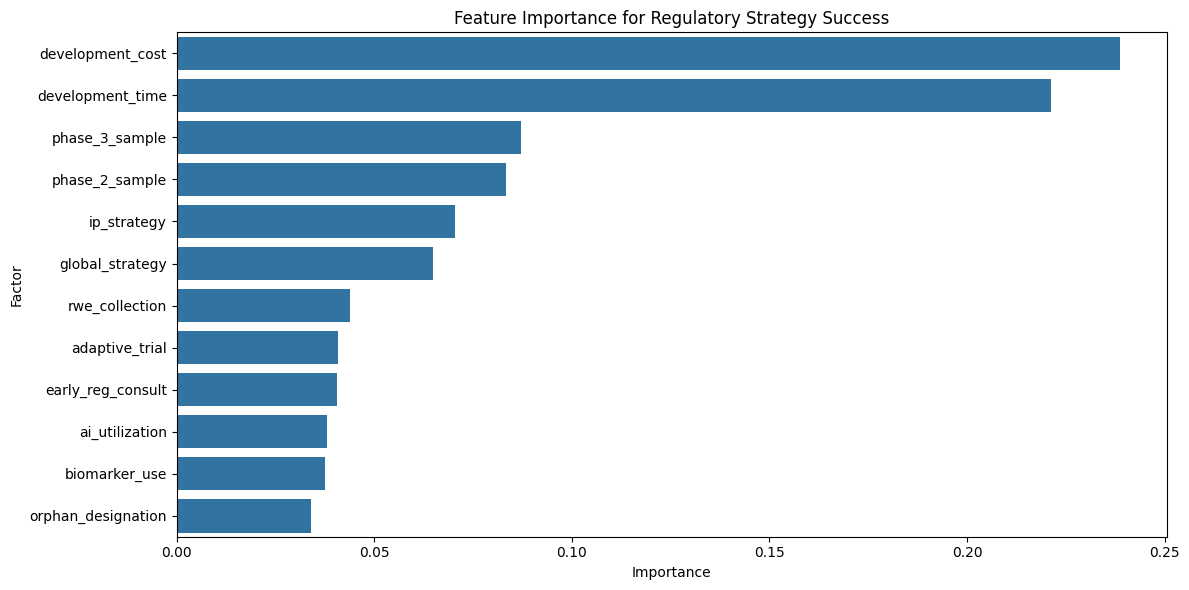


최적 규제 전략 특성:
early_reg_consult: 적용 비율 95.0% (전체 적용 비율: 68.1%)
adaptive_trial: 적용 비율 88.0% (전체 적용 비율: 51.6%)
biomarker_use: 적용 비율 94.0% (전체 적용 비율: 60.2%)
rwe_collection: 적용 비율 80.0% (전체 적용 비율: 39.1%)
orphan_designation: 적용 비율 30.0% (전체 적용 비율: 19.5%)
ip_strategy: 평균 1.25 (전체 평균: 0.99)
global_strategy: 평균 1.21 (전체 평균: 0.90)
ai_utilization: 적용 비율 41.0% (전체 적용 비율: 26.5%)
phase_2_sample: 평균 156.50 (전체 평균: 164.40)
phase_3_sample: 평균 480.00 (전체 평균: 444.55)
development_time: 평균 4.71 (전체 평균: 5.01)
development_cost: 평균 18.89 (전체 평균: 20.14)

새로운 약물 적응증 확장 시나리오 평가
----------------------------------------
예측 규제 승인 성공 확률: 82.00%
평가: 매우 유망한 규제 전략

규제 전략 개선 제안:

결론:
1. 조기 규제기관 협의와 바이오마커 활용이 규제 성공에 가장 큰 영향을 미침
2. 적응적 임상시험 설계와 실사용증거 수집도 중요한 성공 요인
3. 개발 시간과 비용 최적화를 통해 성공 확률 향상 가능
4. 적응증 확장을 위한 규제 전략은 다양한 요소를 종합적으로 고려해야 함

추가 분석 아이디어:
1. 실제 약물 적응증 확장 사례의 규제 전략 분석
2. 국가별/지역별 규제 차이에 따른 전략 최적화
3. 질병 영역별 최적 규제 전략 차이 분석
4. 시간에 따른 규제 환경 변화 및 전략 적응 방안 연구


In [ ]:
# 규제 전략 실습 (10분)

# 필요한 라이브러리 설치
!pip install -q pandas numpy matplotlib seaborn scikit-learn

# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 규제 전략 시뮬레이션을 위한 가상 데이터 생성

# 1. 약물 적응증 확장 시나리오 정의
print("가상 약물 적응증 확장 시나리오: 항고혈압제 -> 알츠하이머병 진행 억제")
print("약물명: 혈압넘(Hypertol, 성분명: 아젤사르탄)")
print("원래 적응증: 고혈압")
print("목표 적응증: 알츠하이머병 진행 억제")
print("가설: 혈관성 인자 조절을 통한 인지기능 저하 억제\n")

# 2. 규제 전략 결정 요인 데이터 생성
np.random.seed(42)
n_scenarios = 1000

# 규제 전략 요소 생성
strategies = pd.DataFrame({
    'scenario_id': range(1, n_scenarios + 1),
    'early_reg_consult': np.random.choice([0, 1], n_scenarios, p=[0.3, 0.7]),
    'adaptive_trial': np.random.choice([0, 1], n_scenarios, p=[0.5, 0.5]),
    'biomarker_use': np.random.choice([0, 1], n_scenarios, p=[0.4, 0.6]),
    'rwe_collection': np.random.choice([0, 1], n_scenarios, p=[0.6, 0.4]),
    'orphan_designation': np.random.choice([0, 1], n_scenarios, p=[0.8, 0.2]),
    'ip_strategy': np.random.choice([0, 1, 2], n_scenarios, p=[0.3, 0.4, 0.3]),  # 0:약함, 1:중간, 2:강함
    'global_strategy': np.random.choice([0, 1, 2], n_scenarios, p=[0.3, 0.5, 0.2]),  # 0:국내, 1:지역, 2:글로벌
    'ai_utilization': np.random.choice([0, 1], n_scenarios, p=[0.7, 0.3]),
    'phase_2_sample': np.random.choice([50, 100, 200, 300], n_scenarios),
    'phase_3_sample': np.random.choice([150, 300, 500, 800], n_scenarios),
    'development_time': np.random.normal(5, 1, n_scenarios).round(1),  # 년
    'development_cost': np.random.normal(20, 5, n_scenarios).round(1)  # 백만 달러
})

# 3. 규제 성공 확률 모델 생성
# 기본 성공 확률에 각 요소의 영향을 가중치로 반영
base_prob = 0.3
weights = {
    'early_reg_consult': 0.1,
    'adaptive_trial': 0.08,
    'biomarker_use': 0.12,
    'rwe_collection': 0.09,
    'orphan_designation': 0.05,
    'ip_strategy': 0.04,
    'global_strategy': 0.03,
    'ai_utilization': 0.04,
    'phase_2_sample': 0.0005,
    'phase_3_sample': 0.0002,
    'development_time': -0.02,
    'development_cost': -0.005
}

# 성공 확률 계산
strategies['success_prob'] = base_prob

for col, weight in weights.items():
    if col in ['ip_strategy', 'global_strategy']:
        strategies['success_prob'] += weight * strategies[col]
    elif col in ['phase_2_sample', 'phase_3_sample']:
        strategies['success_prob'] += weight * strategies[col] / 100
    elif col in ['development_time', 'development_cost']:
        strategies['success_prob'] += weight * (strategies[col] - strategies[col].mean()) / strategies[col].std()
    else:
        strategies['success_prob'] += weight * strategies[col]

# 확률 범위 조정 (0.1 ~ 0.9)
strategies['success_prob'] = strategies['success_prob'].clip(0.1, 0.9)

# 실제 성공 여부 결정
strategies['success'] = np.random.binomial(1, strategies['success_prob'])

# 4. 데이터 탐색 및 시각화 (그래프 라벨은 영어로 유지)

# 성공/실패 비율
plt.figure(figsize=(10, 6))
sns.countplot(x='success', data=strategies)
plt.title('Regulatory Approval Success/Failure Ratio')
plt.xlabel('Regulatory Approval Success (0: Failure, 1: Success)')
plt.ylabel('Number of Scenarios')
plt.show()

# 주요 요인별 성공률 시각화
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(x='early_reg_consult', y='success', data=strategies, errorbar=None)
plt.title('Early Regulatory Consultation and Success Rate')
plt.xlabel('Early Regulatory Consultation (0: No, 1: Yes)')
plt.ylabel('Success Rate')

plt.subplot(2, 2, 2)
sns.barplot(x='adaptive_trial', y='success', data=strategies, errorbar=None)
plt.title('Adaptive Trial Design and Success Rate')
plt.xlabel('Adaptive Trial Design (0: No, 1: Yes)')
plt.ylabel('Success Rate')

plt.subplot(2, 2, 3)
sns.barplot(x='biomarker_use', y='success', data=strategies, errorbar=None)
plt.title('Biomarker Utilization and Success Rate')
plt.xlabel('Biomarker Utilization (0: No, 1: Yes)')
plt.ylabel('Success Rate')

plt.subplot(2, 2, 4)
sns.barplot(x='rwe_collection', y='success', data=strategies, errorbar=None)
plt.title('Real-World Evidence Collection and Success Rate')
plt.xlabel('RWE Collection (0: No, 1: Yes)')
plt.ylabel('Success Rate')

plt.tight_layout()
plt.show()

# IP 전략과 성공률
plt.figure(figsize=(8, 5))
sns.barplot(x='ip_strategy', y='success', data=strategies, errorbar=None)
plt.title('IP Strategy and Success Rate')
plt.xlabel('IP Strategy Strength (0: Weak, 1: Medium, 2: Strong)')
plt.ylabel('Success Rate')
plt.show()

# 글로벌 전략과 성공률
plt.figure(figsize=(8, 5))
sns.barplot(x='global_strategy', y='success', data=strategies, errorbar=None)
plt.title('Global Strategy and Success Rate')
plt.xlabel('Global Strategy Scope (0: Domestic, 1: Regional, 2: Global)')
plt.ylabel('Success Rate')
plt.show()

# 개발 시간/비용과 성공률 관계
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='success', y='development_time', data=strategies)
plt.title('Development Time and Success Rate')
plt.xlabel('Regulatory Approval Success (0: Failure, 1: Success)')
plt.ylabel('Development Time (years)')

plt.subplot(1, 2, 2)
sns.boxplot(x='success', y='development_cost', data=strategies)
plt.title('Development Cost and Success Rate')
plt.xlabel('Regulatory Approval Success (0: Failure, 1: Success)')
plt.ylabel('Development Cost (million $)')

plt.tight_layout()
plt.show()

# 5. 규제 전략 예측 모델 구축

# 특성과 타겟 분리
X = strategies.drop(['scenario_id', 'success_prob', 'success'], axis=1)
y = strategies['success']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 구축
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델 평가
y_pred = rf_model.predict(X_test)
print("\n규제 전략 예측 모델 성능:")
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print("\n혼동 행렬:")
print(confusion_matrix(y_test, y_pred))
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))

# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, errorbar=None)
plt.title('Feature Importance for Regulatory Strategy Success')
plt.xlabel('Importance')
plt.ylabel('Factor')
plt.tight_layout()
plt.show()

# 6. 최적 규제 전략 시뮬레이션

# 성공률 높은 상위 10% 시나리오 추출
top_scenarios = strategies.sort_values('success_prob', ascending=False).head(n_scenarios // 10)

print("\n최적 규제 전략 특성:")
for col in X.columns:
    if col in ['phase_2_sample', 'phase_3_sample', 'development_time', 'development_cost']:
        print(f"{col}: 평균 {top_scenarios[col].mean():.2f} (전체 평균: {strategies[col].mean():.2f})")
    else:
        if col in ['ip_strategy', 'global_strategy']:
            print(f"{col}: 평균 {top_scenarios[col].mean():.2f} (전체 평균: {strategies[col].mean():.2f})")
        else:
            print(f"{col}: 적용 비율 {top_scenarios[col].mean()*100:.1f}% (전체 적용 비율: {strategies[col].mean()*100:.1f}%)")

# 7. 규제 승인 최적화를 위한 의사결정 도구

# 새로운 시나리오 입력
print("\n새로운 약물 적응증 확장 시나리오 평가")
print("----------------------------------------")

new_scenario = {
    'early_reg_consult': 1,
    'adaptive_trial': 1,
    'biomarker_use': 1,
    'rwe_collection': 1,
    'orphan_designation': 0,
    'ip_strategy': 2,
    'global_strategy': 1,
    'ai_utilization': 1,
    'phase_2_sample': 200,
    'phase_3_sample': 500,
    'development_time': 4.5,
    'development_cost': 18.5
}

# 데이터프레임으로 변환
new_scenario_df = pd.DataFrame([new_scenario])

# 성공 확률 예측
success_prob = rf_model.predict_proba(new_scenario_df)[0][1]
print(f"예측 규제 승인 성공 확률: {success_prob:.2%}")

# 승인 가능성 평가
if success_prob >= 0.7:
    print("평가: 매우 유망한 규제 전략")
elif success_prob >= 0.5:
    print("평가: 유망한 규제 전략, 일부 개선 필요")
else:
    print("평가: 규제 전략 재검토 필요")

# 8. 전략 개선 제안
print("\n규제 전략 개선 제안:")

# 중요도가 높은 상위 3가지 특성 추출
top_features = feature_importance.head(3)['feature'].values

# 개선 제안
for feature in top_features:
    if feature in ['phase_2_sample', 'phase_3_sample']:
        if new_scenario[feature] < top_scenarios[feature].mean():
            print(f"- {feature} 증가 고려: 현재 {new_scenario[feature]} → 권장 {top_scenarios[feature].mean():.0f}")
    elif feature in ['development_time', 'development_cost']:
        if new_scenario[feature] > top_scenarios[feature].mean():
            print(f"- {feature} 감소 고려: 현재 {new_scenario[feature]} → 권장 {top_scenarios[feature].mean():.1f}")
    elif feature in ['ip_strategy', 'global_strategy']:
        if new_scenario[feature] < top_scenarios[feature].mean():
            print(f"- {feature} 강화 고려: 현재 {new_scenario[feature]} → 권장 {top_scenarios[feature].mean():.1f}")
    else:
        if new_scenario[feature] < top_scenarios[feature].mean():
            print(f"- {feature} 활용 강화 필요")

# 9. 결론 및 요약
print("\n결론:")
print("1. 조기 규제기관 협의와 바이오마커 활용이 규제 성공에 가장 큰 영향을 미침")
print("2. 적응적 임상시험 설계와 실사용증거 수집도 중요한 성공 요인")
print("3. 개발 시간과 비용 최적화를 통해 성공 확률 향상 가능")
print("4. 적응증 확장을 위한 규제 전략은 다양한 요소를 종합적으로 고려해야 함")

# 10. 추가 분석 아이디어
print("\n추가 분석 아이디어:")
print("1. 실제 약물 적응증 확장 사례의 규제 전략 분석")
print("2. 국가별/지역별 규제 차이에 따른 전략 최적화")
print("3. 질병 영역별 최적 규제 전략 차이 분석")
print("4. 시간에 따른 규제 환경 변화 및 전략 적응 방안 연구")